## Metrics


In [1]:
import torchmetrics
from pathlib import Path

import datetime
from lib.dataloader import *

SEED = 0
np.random.seed(SEED)  # if numpy is used
torch.manual_seed(SEED)

# Directory paths for semantic segmentation dataset
root_dir = Path("/home/emilia/WaterSegNet/datasets/uav_dataset/")
test_root = Path("/home/emilia/WaterSegNet/datasets/uav_dataset/")
dir_test_img = test_root / "test/images"
dir_test_mask = test_root / "test/labels"
dir_train_img = root_dir / "train/images"
dir_train_mask = root_dir / "train/labels"
dir_valid_img = root_dir / "valid/images"
dir_valid_mask = root_dir / "valid/labels"

train_set = SegDataset(dir_train_img, dir_train_mask)
valid_set = SegDataset(dir_valid_img, dir_valid_mask)
test_set = SegDataset(dir_test_img, dir_test_mask)
data_module = SegDataModule(train_set, valid_set, test_set, batch_size=16)


metrics = torchmetrics.MetricCollection(
    torchmetrics.Accuracy(task="binary", num_classes=1, multiclass=False),
    torchmetrics.Recall(task="binary", num_classes=1, multiclass=False),
    torchmetrics.Precision(task="binary", num_classes=1, multiclass=False),
    torchmetrics.F1Score(
        task="binary", num_classes=1, multiclass=False
    ),  # Dice Coefficient
)

train_metrics = torchmetrics.MetricTracker(metrics)
val_metrics = torchmetrics.MetricTracker(metrics)
test_metrics = torchmetrics.MetricTracker(metrics)

## Models


In [2]:
import segmentation_models_pytorch as smp
from segnet.SegNet_model import *

Unet_model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=3,
    classes=1,
    activation=None,
)

Unet_plus_plus_model = smp.UnetPlusPlus(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=3,
    classes=1,
    activation=None,
)

FPN_model = smp.FPN(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=3,
    classes=1,
    activation=None,
)

SegNet_model = SegNet(
    n_channels=3,
    n_classes=1,
)


models = {
    "Unet": Unet_model,
    "Unetplusplus": Unet_plus_plus_model,
    "FPN": FPN_model,
    "SegNet": SegNet_model,
}

/home/emilia/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from lib.train import *
from pytorch_lightning import Trainer


checkpoints_sets = {
    "UAV": "/home/emilia/WaterSegNet/checkpoints/checkpoints_padded/model-UnetPlusPlus_resnet34_adam_b16.ckpt",
    "FULL": "/home/emilia/WaterSegNet/checkpoints/checkpoints_full/model-UNetPlusPlus_resnet34_adam_b16.ckpt",
    "Satellite": "/home/emilia/WaterSegNet/checkpoints/satelite/model-UNetPlusPlus_adam_b16.ckpt",
    # "Sat+UAV": "/home/emilia/WaterSegNet/checkpoints/checkpoints_sat_to_uav/model-unet_resnet34_adam_padded_b16.ckpt",
}

checkpoints_dist_vs_pad = {
    "Distorted": "/home/emilia/WaterSegNet/checkpoints/checkpoints_distorted/model-UNetPlusPlus_resnet34_adam_b16.ckpt",
    "Padded": "/home/emilia/WaterSegNet/checkpoints/checkpoints_padded/model-UnetPlusPlus_resnet34_adam_b16.ckpt",
}

checkpoints_models = {
    "Unet": "//home/emilia/WaterSegNet/checkpoints/checkpoints_padded/model-unet_resnet34_adam_b16.ckpt",
    "Unetplusplus": "/home/emilia/WaterSegNet/checkpoints/checkpoints_padded/model-UnetPlusPlus_resnet34_adam_b16.ckpt",
    "FPN": "/home/emilia/WaterSegNet/checkpoints/checkpoints_padded/model-FPN_resnet34_adam_b16.ckpt",
    "SegNet": "/home/emilia/WaterSegNet/checkpoints/checkpoints_padded/model-Segnet_resnet34_adam_b16.ckpt",
}

checkpoints_batch = {
    "Batch_8": "/home/emilia/WaterSegNet/checkpoints/diff_batch/model-UNetPlusPlus_adam_b8.ckpt",
    "Batch_16": "/home/emilia/WaterSegNet/checkpoints/checkpoints_padded/model-UnetPlusPlus_resnet34_adam_b16.ckpt",
    "Batch_32": "/home/emilia/WaterSegNet/checkpoints/diff_batch/model-UNetPlusPlus_adam_b32.ckpt",
}

checkpoints_optimizers = {
    "adam": "/home/emilia/WaterSegNet/checkpoints/checkpoints_padded/model-UnetPlusPlus_resnet34_adam_b16.ckpt",
    "adamw": "/home/emilia/WaterSegNet/checkpoints/diff_optim/model-UNetPlusPlus_adamw_b16.ckpt",
    "sgd": "/home/emilia/WaterSegNet/checkpoints/diff_optim/model-UNetPlusPlus_sgd_b16.ckpt",
    "rmsprop": "/home/emilia/WaterSegNet/checkpoints/diff_optim/model-UNetPlusPlus_rmsprop_b16.ckpt",
}

In [4]:
import torch

test_set = SegDataset(dir_test_img, dir_test_mask)
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False)


def test(model, device, test_loader, checkpoint_name):
    model.eval()
    test_loss = 0
    total_precision = 0
    total_dice = 0

    with torch.no_grad():
        for sample in test_loader:
            imgs, gt_masks = sample["image"], sample["mask"]
            data, target = imgs.to(device), gt_masks.to(device).float()
            output = model(data)

            test_loss += F.binary_cross_entropy_with_logits(
                output.squeeze(1), target, reduction="sum"
            ).item()

            probs = torch.sigmoid(output)
            preds = (probs > 0.5).float().squeeze(1)
            intersection = (preds * target).sum((1, 2))

            # Dice coefficient calculation
            dice = (2 * intersection + 1e-6) / (
                preds.sum((1, 2)) + target.sum((1, 2)) + 1e-6
            )
            total_dice += dice.sum().item()

            # Precision calculation
            precision = intersection / (preds.sum((1, 2)) + 1e-6)
            total_precision += precision.sum().item()

    test_loss /= len(test_loader.dataset)
    average_precision = total_precision / len(test_loader.dataset)
    average_dice = total_dice / len(test_loader.dataset)

    print(
        f"\n{checkpoint_name}: Average loss: {test_loss:.4f}, Average Precision: {average_precision:.4f}, "
        f"Average Dice: {average_dice:.4f}\n"
    )


def test_model(checkpoints):
    print("############################################")
    for i in checkpoints:
        checkpoint = torch.load(checkpoints[i])
        state_dict = checkpoint["state_dict"]
        model = smp.UnetPlusPlus(
            encoder_name="resnet34",
            encoder_weights=None,
            in_channels=3,
            classes=1,
            activation=None,
        )
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        model.load_state_dict(state_dict)
        test(model, device, test_dataloader, i)


def test_models():
    print("############################################")

    for i in checkpoints_models:
        model = models[i]
        checkpoint = torch.load(checkpoints_models[i])
        state_dict = checkpoint["state_dict"]
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        model.load_state_dict(state_dict)
        test(model, device, test_dataloader, i)


test_model(checkpoints_dist_vs_pad)
# test_models()

############################################

Distorted: Average loss: 3698.5420, Average Precision: 0.9683, Average Dice: 0.9721


Padded: Average loss: 7202.0214, Average Precision: 0.9532, Average Dice: 0.9442



/tmp/ipykernel_48234/2844633194.py:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x="epoch", y=val_data, hue="Optimizer", data=combined_data, ci=None)
/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector)

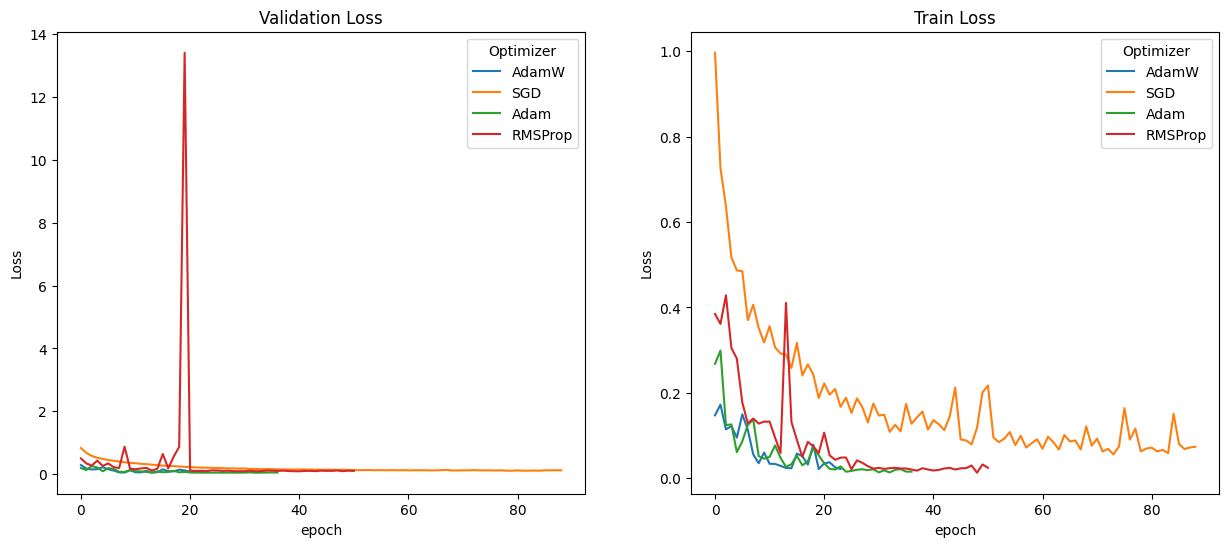

/tmp/ipykernel_48234/2844633194.py:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x="epoch", y=val_data, hue="Optimizer", data=combined_data, ci=None)
/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector)

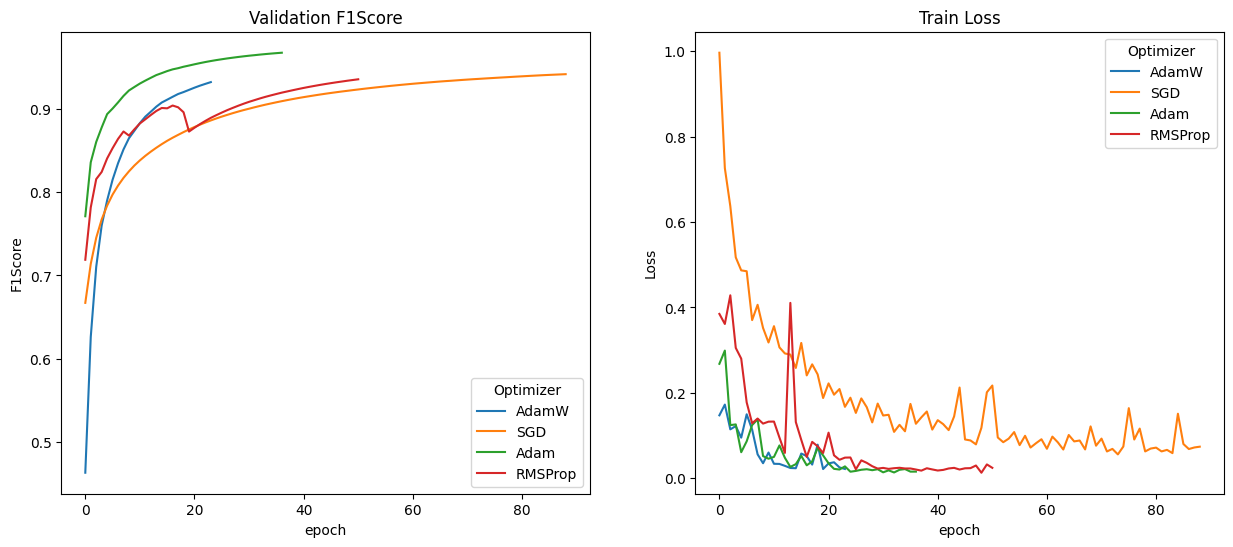

In [9]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os


def create_metric_df(ea, metric_name):
    """Create a DataFrame for a specific metric if available."""
    if metric_name in ea.scalars.Keys():
        return pd.DataFrame(
            {
                "Step": [s.step for s in ea.scalars.Items(metric_name)],
                metric_name: [s.value for s in ea.scalars.Items(metric_name)],
            }
        )
    else:
        return pd.DataFrame()  # Return empty DataFrame if metric is not available


def plot_metrics(metric, train_data, val_data):
    """Plot the specified metrics against epochs."""
    # Plot using Seaborn
    plt.figure(figsize=(15, 6))

    # Validation Loss plot
    plt.subplot(1, 2, 1)
    sns.lineplot(x="epoch", y=val_data, hue="Optimizer", data=combined_data, ci=None)
    plt.title(f"Validation {metric}")
    plt.ylabel(metric)

    # Train Loss plot
    plt.subplot(1, 2, 2)
    sns.lineplot(x="epoch", y=train_data, hue="Optimizer", data=combined_data, ci=None)
    plt.title(f"Train Loss")
    plt.ylabel("Loss")

    plt.show()


log_dir = "/home/emilia/WaterSegNet/optim_logs"
ea = EventAccumulator(log_dir)
ea.Reload()
metrics = ea.scalars.Keys()
# Iterate over each file in the log directory
data_frames = []
for file_name in os.listdir(log_dir):
    file_path = os.path.join(log_dir, file_name)
    run_name = file_name.split(".")[0]

    # Load the data from each file
    ea = EventAccumulator(file_path)
    ea.Reload()

    # Create DataFrames for each metric including epoch
    metric_dfs = {metric: create_metric_df(ea, metric) for metric in metrics}
    metric_dfs = {
        k: v for k, v in metric_dfs.items() if not v.empty
    }  # Filter out empty DataFrames

    if "epoch" in metric_dfs and metric_dfs:  # Ensure epoch data is present
        # Merge all metrics with epoch DataFrame
        base_df = metric_dfs["epoch"]
        for metric, df in metric_dfs.items():
            if metric != "epoch":
                merged_df = pd.merge(base_df, df, on="Step")
                merged_df["Optimizer"] = run_name
                data_frames.append(merged_df)

# Combine all data frames
combined_data = pd.concat(data_frames, ignore_index=True)

# Plot using Seaborn
plot_metrics("Loss", "train_loss", "val_loss")
# plot_metrics("Accuracy", "train.Accuracy", "val.Accuracy")
# plot_metrics("Recall", "train.Recall", "val.Recall")
# plot_metrics("Precision", "train.Precision", "val.Precision")
plot_metrics("F1Score", "train_loss", "val.F1Score")

/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


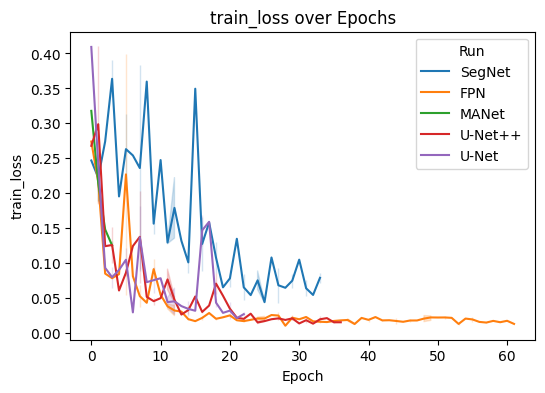

/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


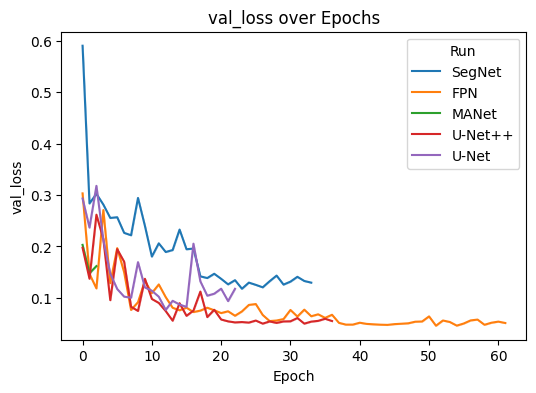

/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


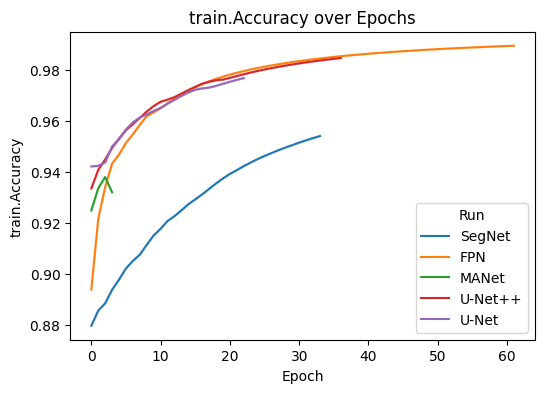

/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


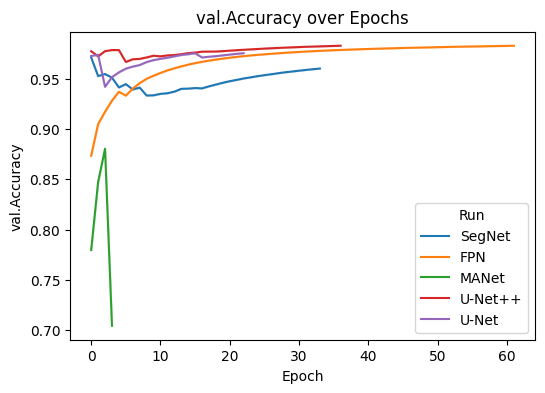

/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


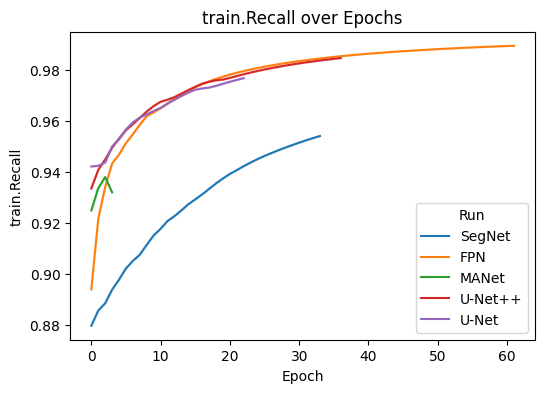

/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


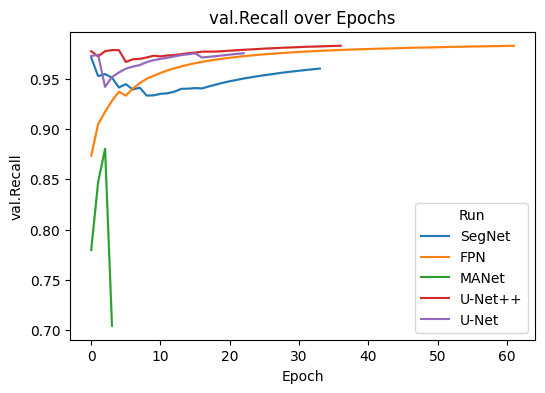

/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


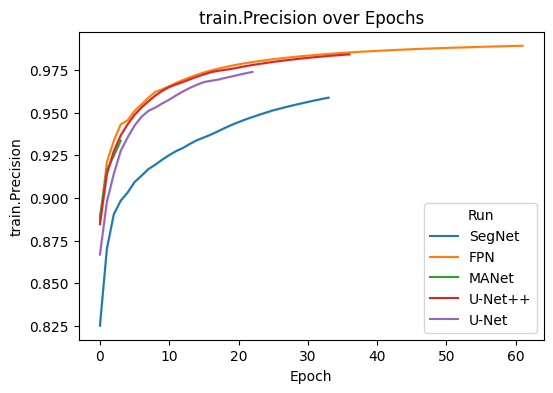

/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


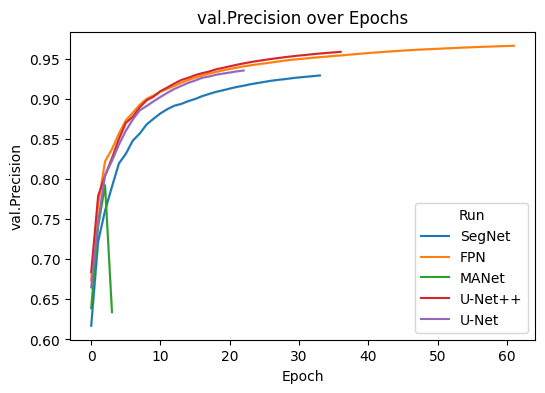

/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


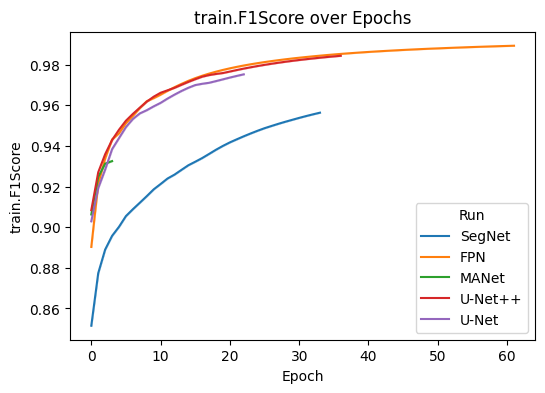

/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/emilia/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


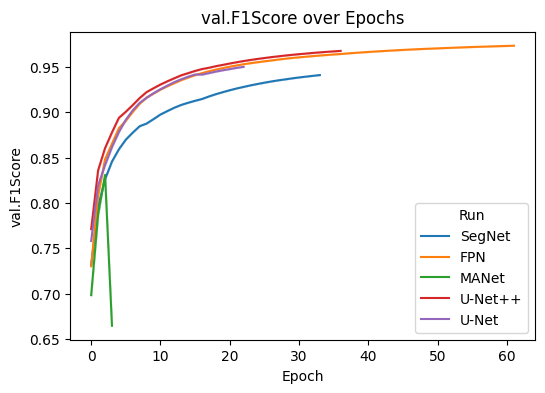

In [27]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os


def create_metric_df(ea, metric_name):
    """Create a DataFrame for a specific metric if available."""
    if metric_name in ea.scalars.Keys():
        return pd.DataFrame(
            {
                "Step": [s.step for s in ea.scalars.Items(metric_name)],
                metric_name: [s.value for s in ea.scalars.Items(metric_name)],
            }
        )
    else:
        return pd.DataFrame()  # Return empty DataFrame if metric is not available


def plot_metrics(data, metrics):
    """Plot the specified metrics against epochs."""
    for metric in metrics:
        if metric != "epoch":
            plt.figure(figsize=(6, 4))
            sns.lineplot(x="epoch", y=metric, hue="Run", data=data)
            plt.title(f"{metric} over Epochs")
            plt.xlabel("Epoch")
            plt.ylabel(metric)
            plt.show()


log_dir = "/home/emilia/WaterSegNet/model_logs"
metrics = [
    "epoch",
    "train_loss",
    "val_loss",
    "train.Accuracy",
    "val.Accuracy",
    "train.Recall",
    "val.Recall",
    "train.Precision",
    "val.Precision",
    "train.F1Score",
    "val.F1Score",
]

# Iterate over each file in the log directory
data_frames = []
for file_name in os.listdir(log_dir):
    file_path = os.path.join(log_dir, file_name)
    run_name = file_name.split(".")[0]

    # Load the data from each file
    ea = EventAccumulator(file_path)
    ea.Reload()

    # Create DataFrames for each metric including epoch
    metric_dfs = {metric: create_metric_df(ea, metric) for metric in metrics}
    metric_dfs = {
        k: v for k, v in metric_dfs.items() if not v.empty
    }  # Filter out empty DataFrames

    if "epoch" in metric_dfs and metric_dfs:  # Ensure epoch data is present
        # Merge all metrics with epoch DataFrame
        base_df = metric_dfs["epoch"]
        for metric, df in metric_dfs.items():
            if metric != "epoch":
                merged_df = pd.merge(base_df, df, on="Step")
                merged_df["Run"] = run_name
                data_frames.append(merged_df)

# Combine all data frames
combined_data = pd.concat(data_frames, ignore_index=True)

# Plot using Seaborn
plot_metrics(combined_data, metrics)

### Compute inference time


In [5]:
import time
import torch  # or import tensorflow as tf


def remove_border(mask, original_size):
    h, w = mask.shape
    orig_h, orig_w = original_size
    delta_w = w - orig_w
    delta_h = h - orig_h

    if delta_w > 0:
        mask = mask[:, delta_w // 2 : -delta_w // 2]
    if delta_h > 0:
        mask = mask[delta_h // 2 : -delta_h // 2, :]
    return mask


def predict_image(model, image, device):
    model.eval()
    img = torch.from_numpy(SegDataset.preprocess(image, is_mask=False))
    img = img.unsqueeze(0).to(device, dtype=torch.float32)
    with torch.no_grad():
        pred = model(img).cpu()
        max_dim = max(image.size)
        pred = F.interpolate(pred, size=(max_dim, max_dim))
        mask = torch.sigmoid(pred) > 0.5

    mask_np = mask[0].long().squeeze().numpy()
    mask_np = remove_border(mask_np, original_size=(image.size[1], image.size[0]))
    return mask_np


def measure_inference_time(model, device):
    img_arr = []
    # If using a GPU, move the model and input tensor to the GPU
    for i in range(10, 99):
        image_raw = Image.open(
            "/home/emilia/WaterSegNet/datasets/uav_dataset/train/images/00"
            + str(i)
            + ".png"
        )
        img_arr.append(image_raw)
        image_raw = Image.open(
            "/home/emilia/WaterSegNet/datasets/uav_dataset/train/images/0"
            + str(i)
            + "0.png"
        )
        img_arr.append(image_raw)

    # Warm-up runs
    for i in range(len(img_arr)):
        mask = predict_image(model, img_arr[i], device)

    # Perform multiple inferences and measure the average time
    total_time = 0

    for i in range(len(img_arr)):
        start_time = time.time()
        # Perform the inference
        mask = predict_image(model, img_arr[i], device)

        total_time += time.time() - start_time

    average_time = total_time / len(img_arr)

    print(f"Average inference time over {len(img_arr)} runs: {average_time} seconds")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for i in checkpoints_dist_vs_pad:
    print(i)
    model = models["Unetplusplus"]
    model.to(device)
    model.load_state_dict(torch.load(checkpoints_models["Unetplusplus"])["state_dict"])

    measure_inference_time(model, device)

Distorted
Average inference time over 178 runs: 0.03237622105673458 seconds
Padded
Average inference time over 178 runs: 0.032393136720978814 seconds
